Epoch 1/125
11/11 [==============================] - 15s 1s/step - loss: 0.9874 - accuracy: 0.6047 - val_loss: 5.7176 - val_accuracy: 0.5116
Epoch 2/125
11/11 [==============================] - 13s 1s/step - loss: 0.9167 - accuracy: 0.6657 - val_loss: 3.4243 - val_accuracy: 0.5116
Epoch 3/125
11/11 [==============================] - 13s 1s/step - loss: 0.8756 - accuracy: 0.7297 - val_loss: 3.5012 - val_accuracy: 0.5116
Epoch 4/125
11/11 [==============================] - 13s 1s/step - loss: 0.6690 - accuracy: 0.7297 - val_loss: 3.0127 - val_accuracy: 0.5116
Epoch 5/125
11/11 [==============================] - 13s 1s/step - loss: 0.6703 - accuracy: 0.7471 - val_loss: 1.5444 - val_accuracy: 0.5581
Epoch 6/125
11/11 [==============================] - 14s 1s/step - loss: 0.6874 - accuracy: 0.7326 - val_loss: 0.8670 - val_accuracy: 0.6279
Epoch 7/125
11/11 [==============================] - 13s 1s/step - loss: 0.6781 - accuracy: 0.7558 - val_loss: 0.7909 - val_accuracy: 0.6512
Epoch 8/125
1

Epoch 59/125
11/11 [==============================] - 12s 1s/step - loss: 0.3026 - accuracy: 0.8779 - val_loss: 0.4741 - val_accuracy: 0.7907
Epoch 60/125
11/11 [==============================] - 12s 1s/step - loss: 0.3820 - accuracy: 0.8576 - val_loss: 0.3986 - val_accuracy: 0.7907
Epoch 61/125
11/11 [==============================] - 12s 1s/step - loss: 0.2963 - accuracy: 0.8779 - val_loss: 0.5157 - val_accuracy: 0.7209
Epoch 62/125
11/11 [==============================] - 12s 1s/step - loss: 0.2873 - accuracy: 0.8837 - val_loss: 0.5582 - val_accuracy: 0.7326
Epoch 63/125
11/11 [==============================] - 12s 1s/step - loss: 0.3333 - accuracy: 0.8547 - val_loss: 0.7105 - val_accuracy: 0.7093
Epoch 64/125
11/11 [==============================] - 12s 1s/step - loss: 0.3434 - accuracy: 0.8634 - val_loss: 0.7366 - val_accuracy: 0.7093
Epoch 65/125
11/11 [==============================] - 12s 1s/step - loss: 0.2668 - accuracy: 0.8983 - val_loss: 0.5566 - val_accuracy: 0.7674
Epoch 

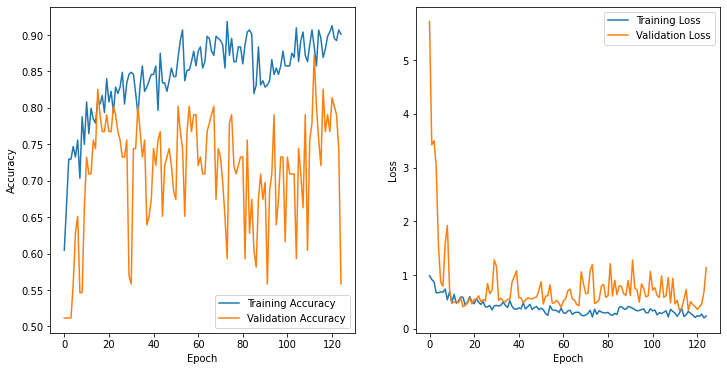

3/3 [==============================] - 0s 48ms/step
Classification Report:
              precision    recall  f1-score   support

       covid       1.00      0.14      0.24        36
      normal       0.53      1.00      0.69        50

    accuracy                           0.56        86
   macro avg       0.76      0.57      0.46        86
weighted avg       0.77      0.56      0.46        86



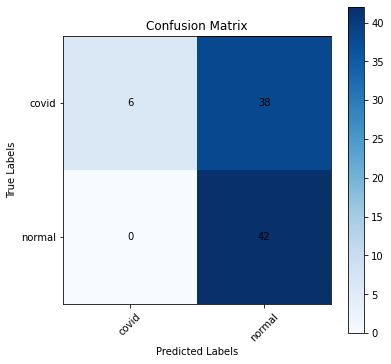

In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import tensorflow as tf

# Define the paths to the dataset directories
covid_dir = "C:/Users/Cheeyee/3009/CovidClassification/dataset_6/covid"
normal_dir = "C:/Users/Cheeyee/3009/CovidClassification/dataset_6/normal"

# Function to load images and labels from the given directory
def load_data_from_directory(directory, label):
    images = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (299, 299))
            images.append(img)
            labels.append(label)
    return images, labels

# Load COVID images and labels
covid_images, covid_labels = load_data_from_directory(covid_dir, "covid")

# Load normal images and labels
normal_images, normal_labels = load_data_from_directory(normal_dir, "normal")

# Combine the data and labels for COVID and normal images
X_data = np.array(covid_images + normal_images)
y_data = np.array(covid_labels + normal_labels)

# Convert labels to one-hot encoded vectors
label_encoder = LabelEncoder()
y_data = label_encoder.fit_transform(y_data)
y_data = tf.keras.utils.to_categorical(y_data)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42, stratify=y_data)

# Flatten the images to use as input in the MLP
input_shape = X_train.shape[1] * X_train.shape[2] * X_train.shape[3]
X_train_flat = X_train.reshape(X_train.shape[0], input_shape)
X_test_flat = X_test.reshape(X_test.shape[0], input_shape)

# Normalize pixel values to [0, 1]
X_train_flat = X_train_flat / 255.0
X_test_flat = X_test_flat / 255.0

# Create a Multi-Layer Perceptron (MLP) model with more units
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(input_shape,)),
    tf.keras.layers.BatchNormalization(),  # Add BatchNormalization layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),  # Add BatchNormalization layer
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Define a learning rate schedule with a smaller initial learning rate
initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# Compile the model with the new learning rate
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), metrics=['accuracy'])

# Train the model (without data augmentation and early stopping)
history = model.fit(X_train_flat, y_train, batch_size=32, epochs=125, validation_data=(X_test_flat, y_test))

# Plotting accuracy and loss over epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
y_pred = model.predict(X_test_flat)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_))

# Display the confusion matrix
conf_matrix = confusion_matrix(y_true_labels, y_pred_labels)
plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
class_names = label_encoder.classes_
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.colorbar()

for i in range(len(class_names)):
    for j in range(len(class_names)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center')

plt.show()